In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import re
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
%autoreload

from utils import *
from project_debater_api import *
from mt_bart_v2 import *

In [4]:
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib.pyplot as plt

In [5]:
from tabulate import tabulate

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
device

device(type='cuda')

In [9]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [10]:
def generate_ds_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=16):
    ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm), batched=True)
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
    attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
    
    return attacks

def create_predictions_df(reddit_sample_valid_ds, gen_kwargs, premises_clm='masked_premises'):
    
    joint_attacks       = generate_ds_attacks(reddit_sample_valid_ds, join_model, join_model_tokenizer, premises_clm, None, gen_kwargs)
    known_conc_attacks  = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'title', gen_kwargs)
    bart_conc_attacks   = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'bart_conclusion', gen_kwargs)
    arglex_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'arglex_rank_conclusion', gen_kwargs)
    masked_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    #update max_gen_length to account to the generated conclusion
    gen_kwargs['max_length'] = gen_kwargs['max_length'] + 30
    joint_conc_baseline_attacks  = generate_ds_attacks(reddit_sample_valid_ds, pred_conclusion_model, pred_conclusion_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    #This model would predict the conclusion and then the counter in one sequence.

    reddit_pred_df = pd.DataFrame(list(zip(
                                           reddit_sample_valid_ds['post_id'],
                                           reddit_sample_valid_ds['title'], 
                                           reddit_sample_valid_ds['conclusion_targets'],
                                           reddit_sample_valid_ds['conclusion_stance'],
                                           reddit_sample_valid_ds['bart_conclusion'], 
                                           reddit_sample_valid_ds['arglex_rank_conclusion'], 
                                           reddit_sample_valid_ds[premises_clm],
                                           reddit_sample_valid_ds['counter'], 
                                           known_conc_attacks, masked_conc_attacks, 
                                           bart_conc_attacks, arglex_conc_attacks, joint_attacks, joint_conc_baseline_attacks)), 
                    columns=['post_id', 'conclusion', 'conclusion_target', 'conclusion_stance', 'bart_conclusion', 'arglex_rank_conclusion', 'premises', 'gt_attack', 'known_conc_attacks', 
                             'masked_conc_attacks', 'bart_conc_attacks', 'arglex_conc_attacks', 'joint_conc_attacks', 'joint_conc_baseline_attacks'])

    reddit_pred_df['argument'] = reddit_pred_df.apply(lambda row: row['conclusion'] + ' : ' + ' '.join(row['premises']), axis=1)
    reddit_pred_df['premises'] = reddit_pred_df['premises'].apply(lambda x: ' '.join(x))

    #process the jointly generated conclusion and counter
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    return reddit_pred_df

def get_evaluation_results(reddit_pred_df, df_path):
    
    #collect references
    df = pd.read_pickle(df_path)
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x[0:10]]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['gt_attack'] = reddit_pred_df['gt_attack'].apply(lambda x: str(x))
    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]

    masked_conc_eval = evaluate_gen_attacks(reddit_pred_df['masked_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    known_conc_eval  = evaluate_gen_attacks(reddit_pred_df['known_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    bart_conc_eval   = evaluate_gen_attacks(reddit_pred_df['bart_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    arglex_conc_eval = evaluate_gen_attacks(reddit_pred_df['arglex_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    pred_conc_eval   = evaluate_gen_attacks(reddit_pred_df['joint_conc_baseline_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    joint_conc_eval  = evaluate_gen_attacks(reddit_pred_df['joint_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    
    #Test stance correctness
    filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    
    
    #compute the stance of the generated counters towards the conclusion target
    filtered_reddit_pred_df['masked_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.masked_conc_attacks.tolist())
    filtered_reddit_pred_df['known_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.known_conc_attacks.tolist())
    filtered_reddit_pred_df['bart_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.bart_conc_attacks.tolist())
    filtered_reddit_pred_df['arglex_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.arglex_conc_attacks.tolist())
    filtered_reddit_pred_df['pred_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    filtered_reddit_pred_df['joint_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_attacks.tolist())
    
    #compute the distance between the conclusion stance and the attack stance: the bigger the distance the better...
    masked_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    known_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    bart_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    arglex_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.arglex_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    pred_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    joint_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)

    #check if the two stances are contradicotry
    #masked_conc_stance_score2 = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #known_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #bart_conc_stance_score2   = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #pred_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #joint_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    return {'Masked Conclusion': masked_conc_eval,
            'BART Conclusion': bart_conc_eval,
            'ArgLexRank Conclusion': arglex_conc_eval,
            'Joint Prediction (baseline)': pred_conc_eval,
            'Joint Prediction': joint_conc_eval,
            'Known Conclusion': known_conc_eval,
            'preds_df' : reddit_pred_df,
            'stances_df': filtered_reddit_pred_df}


def print_results(pred_df_scores):
    print(tabulate([['Masked Conclusion'] + [pred_df_scores['Masked Conclusion']['bleu'], pred_df_scores['Masked Conclusion']['bert-fscore'], pred_df_scores['Masked Conclusion']['stance_score']],
                    ['BART Conclusion'] + [pred_df_scores['BART Conclusion']['bleu'], pred_df_scores['BART Conclusion']['bert-fscore'], pred_df_scores['BART Conclusion']['stance_score']],
                    ['ArgLexRank Conclusion'] + [pred_df_scores['ArgLexRank Conclusion']['bleu'], pred_df_scores['ArgLexRank Conclusion']['bert-fscore'], pred_df_scores['ArgLexRank Conclusion']['stance_score']],
                    ['Joint Prediction (baseline)'] + [pred_df_scores['Joint Prediction (baseline)']['bleu'], pred_df_scores['Joint Prediction (baseline)']['bert-fscore'], pred_df_scores['Joint Prediction (baseline)']['stance_score']],
                    ['Joint Prediction'] + [pred_df_scores['Joint Prediction']['bleu'], pred_df_scores['Joint Prediction']['bert-fscore'], pred_df_scores['Joint Prediction']['stance_score']],
                    ['Known Conclusion'] + [pred_df_scores['Known Conclusion']['bleu'], pred_df_scores['Known Conclusion']['bert-fscore'], pred_df_scores['Known Conclusion']['stance_score']],
        ], headers=['bleu', 'bert-f1score', 'stance-score (diff)']))

    print('=======')
    #Check significancy:
    print('BART vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores']))
    print('BART vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores']))
    print('-------')
    print('Joint Prediction (baseline) vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores']))
    print('Joint Prediction (baseline) vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores']))
    print('-------')
    print('Joint Prediction vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores']))
    print('Joint Prediction vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores']))
    print('-------')
    print('Known Conclusion vs baseline (BLEU):', check_sig(pred_df_scores['Known Conclusion']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores']))
    print('Known Conclusion vs baseline (BERT):', check_sig(pred_df_scores['Known Conclusion']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores']))

----------------------

## Test Models trained on all data for different levels of conclusion masking:

In [11]:
data_unique_path = '/reddit_data/conclusion_and_ca_generation/valid_conclusion_all_sample_with_targets_with_arglexrank_conclusions.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/valid_conclusion_all.pkl'

In [12]:
# Loading Reddit models
known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/valid-ft-all/known-conc-model-2e-05-32').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/valid-ft-all/known-conc-model-2e-05-32')

pred_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/valid-ft-all/pred-conc-model-2e-05-32/').to(device)
pred_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/valid-ft-all/pred-conc-model-2e-05-32/')

join_model_tokenizer = BartTokenizer.from_pretrained('../data/output/valid-ft-all/mt-model-5e-05-32/checkpoint-7500/')
join_model  = BartModelV2.from_pretrained('../data/output/valid-ft-all/mt-model-5e-05-32/checkpoint-7500/', compute_dynamic_weights=True, conc_decoder=True).to(device)

In [13]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [15]:
levels_of_masking = [1.0, 0.75, 0.6, 0.5]

gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "num_beams":10
}

In [ ]:
all_pred_scores = []
for lvl in levels_of_masking:
    masked_clm = '{}_perc_masked_premises'.format(lvl*10)
    valid_df = remove_similar_sents(valid_df, threshold=lvl, masked_clm = masked_clm)

    #Create a dataset
    unique_valid_posts = valid_df.drop_duplicates('post_id')
    valid_ds = Dataset.from_pandas(unique_valid_posts)
    #If we want to take a small sample..
    #valid_ds = valid_ds.train_test_split(0.5)
    #valid_ds = valid_ds['test']
    valid_ds = valid_ds.flatten_indices()

    #generate predictions
    reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm=masked_clm)
    reddit_pred_df.to_pickle('../data/output/reddit_pred_df_{}.pkl'.format(masked_clm))
    
    pred_df_scores = get_evaluation_results(reddit_pred_df, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores.append(pred_df_scores)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

#### Evaluate performance on different level of argument-lengths:

In [80]:
import scipy.stats as stats

In [88]:
#reddit_pred_df = pd.read_pickle('../data/output/reddit_all_data_masked_premises_pred_df-nosample-beamsize-4.pkl')
reddit_pred_df = pd.read_pickle('../data/output/reddit_all_data_pred_df-nosample-beamsize-4.pkl')

In [89]:
reddit_pred_df['arg_len'] = reddit_pred_df.premises.apply(lambda x: len(nltk.word_tokenize(x)))

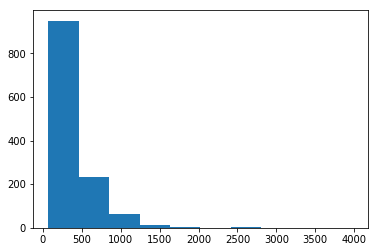

DescribeResult(nobs=1266, minmax=(69, 3980), mean=371.4462875197472, variance=94355.3065988548, skewness=3.6248924595462295, kurtosis=25.435689418974672)
Median: 120.0


In [90]:
arg_len_dist = reddit_pred_df.arg_len.tolist()
plt.hist(arg_len_dist)
plt.show()
print(stats.describe(arg_len_dist))
print('Median:', stats.median_abs_deviation(arg_len_dist))

In [91]:
print('Num of arguments longer than the median:', len([x for x in arg_len_dist if x < 120]))
print('Num of arguments shorter than the median:', len([x for x in arg_len_dist if x > 120]))

Num of arguments longer than the median: 84
Num of arguments shorter than the median: 1181


In [92]:
short_arg_pred_df_scores = get_evaluation_results(reddit_pred_df[reddit_pred_df.arg_len <= 120],  ceph_dir + '/reddit_data/conclusion_and_ca_generation/valid_conclusion_comp_remove_75sem_perc.pkl')
long_arg_pred_df_scores = get_evaluation_results(reddit_pred_df[reddit_pred_df.arg_len > 120],  ceph_dir + '/reddit_data/conclusion_and_ca_generation/valid_conclusion_comp_remove_75sem_perc.pkl')

ProConClient: 100%|██████████| 1198/1198 [1:55:35<00:00,  5.79s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ProConClient: 100%|██████████| 83/83 [00:00<00:00, 157.96it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [93]:
print_results(short_arg_pred_df_scores)

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.182676        0.160757                   0.85
BART Conclusion              0.239127        0.203622                   0.82
ArgLexRank Conclusion        0.17765         0.149343                   0.78
Joint Prediction (baseline)  0.175237        0.169731                   0.7
Joint Prediction             0.25985         0.199717                   0.82
Known Conclusion             0.264454        0.208966                   0.7
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): True
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is normal, so using ttest_rel
Joint Prediction (baseline) vs baseline (BERT): False
-------
Distribution is not 

In [94]:
print_results(long_arg_pred_df_scores)

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.151293        0.137899                   0.74
BART Conclusion              0.168714        0.178853                   0.69
ArgLexRank Conclusion        0.137489        0.127679                   0.77
Joint Prediction (baseline)  0.161659        0.160567                   0.77
Joint Prediction             0.186468        0.150083                   0.78
Known Conclusion             0.201845        0.179771                   0.66
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 1115/1115 [00:31<00:00, 47.97it/s]